In [1]:
import utils

In [2]:
import json
import os

MAP = "zig-zag"

dwa = utils.load_data(os.path.abspath("dumped_data"), MAP, "dwa")
tr = utils.load_data(os.path.abspath("dumped_data"), MAP, "tr")
teb = utils.load_data(os.path.abspath("dumped_data"), MAP, "teb")
mpc = utils.load_data(os.path.abspath("dumped_data"), MAP, "mpc")

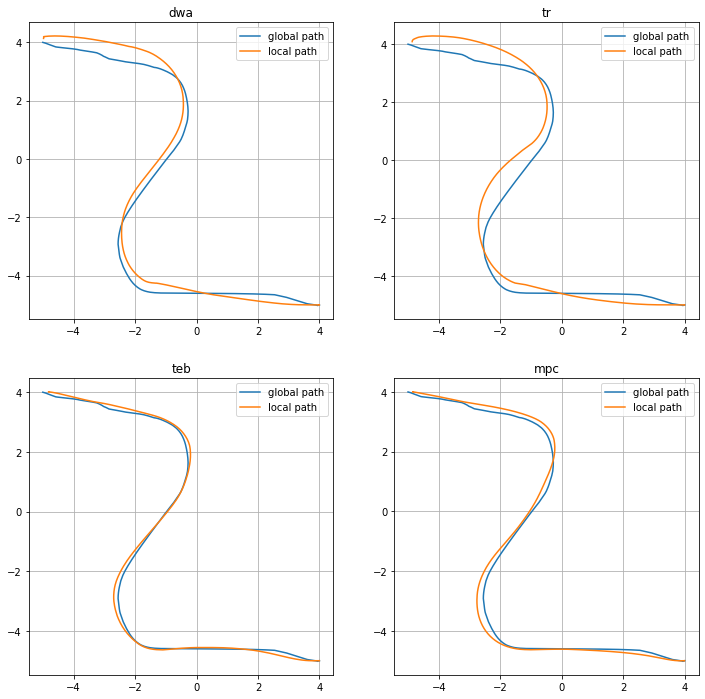

In [3]:
import matplotlib.pyplot as plt

fig, axs = plt.subplots(2, 2, figsize=(12, 12))

for i, approach in enumerate([dwa, tr, teb, mpc]):
    ax = axs[i//2][i%2]
    ax.grid(True, "both")
    ax.plot(approach.global_path.x, approach.global_path.y, label="global path")
    ax.plot(approach.local_path.x, approach.local_path.y, label="local path")
    ax.title.set_text(approach.approach_name)
    ax.legend()

plt.show()


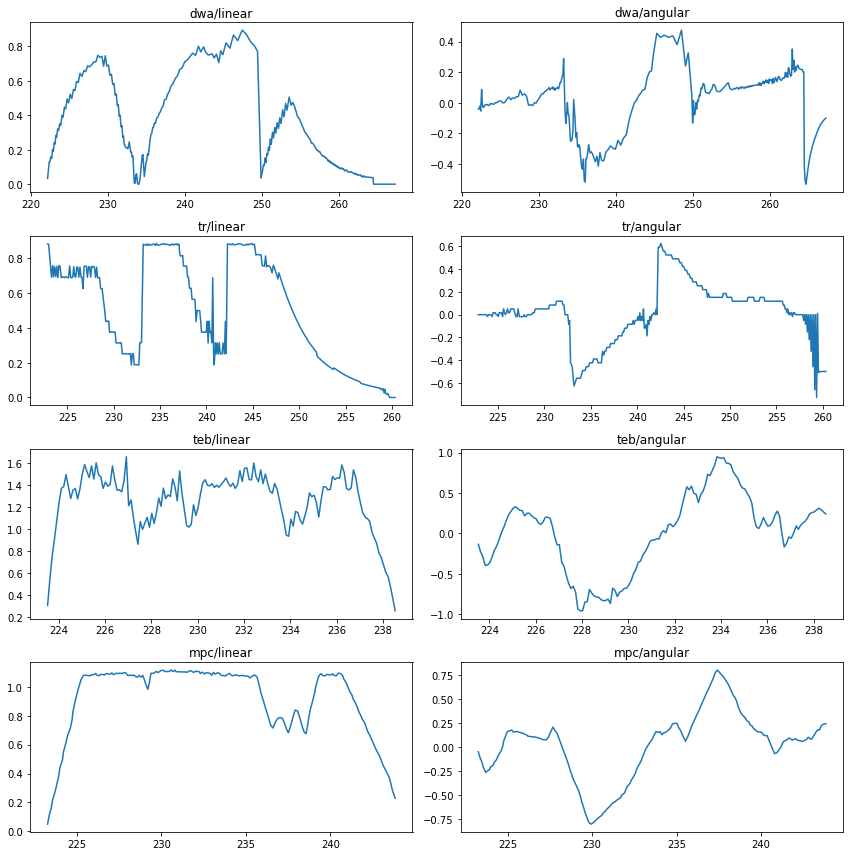

In [4]:
import matplotlib.pyplot as plt

fig, axs = plt.subplots(4, 2, figsize=(12, 12))

map(lambda ax: ax.grid(True, "both"), [ax for sublist in axs for ax in sublist])

for i, approach in enumerate([dwa, tr, teb, mpc]):
    axs[i][0].plot(approach.velocity.t, approach.velocity.linear)
    axs[i][1].plot(approach.velocity.t, approach.velocity.angular)
    axs[i][0].title.set_text(f"{approach.approach_name}/linear")
    axs[i][1].title.set_text(f"{approach.approach_name}/angular")

fig.tight_layout()
plt.show()

#### Гладкость скоростей

In [5]:
import pandas as pd

smoothness = {a.approach_name: {"linear": 0, "angular": 0} for a in [dwa, tr, teb, mpc]}
for a, t in [(a, t) for a in [dwa, tr, teb, mpc] for t in ["linear", "angular"]]:
    smoothness[a.approach_name][t] = utils.evaluate_smoothness(a.velocity, "t", t, angle_fix=t=="angular")

smoothness = pd.DataFrame(smoothness).T
smoothness["common"] = smoothness.linear + smoothness.angular
smoothness.round(3)

,linear,angular,common
dwa,11.195,30.090,41.285
tr,23.316,28.333,51.649
teb,11.498,5.541,17.038
mpc,5.646,4.139,9.785


#### Гладкость пути

In [6]:

{a.approach_name: utils.evaluate_smoothness(a.local_path, "t", "x", "y") for a in [dwa, tr, teb, mpc]}

{'dwa': 1.530428280041366,
 'tr': 1.3794491796347799,
 'teb': 1.01017968912073,
 'mpc': 1.027015951695471}

#### Отклонение от маршрута

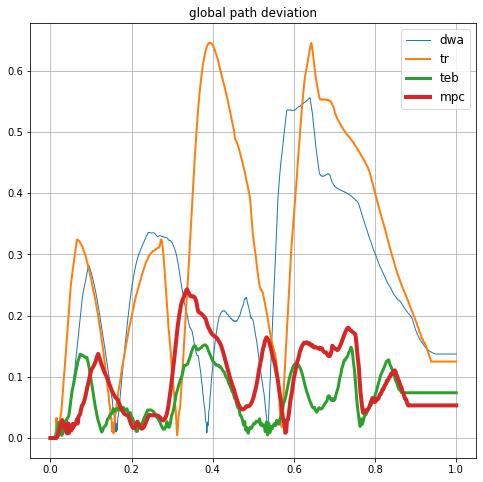

In [7]:
normalize = lambda data: (data - data.min())/(data.max() - data.min())

plt.figure(figsize=(8, 8))
plt.grid(True, "both")
plt.title("global path deviation")
for w, a in enumerate([dwa, tr, teb, mpc], start=1):
    plt.plot(
        normalize(a.global_path_deviation.t),
        a.global_path_deviation.dist,
        linewidth=w, label=f"{a.approach_name}"
    )
plt.legend(fontsize="large")
plt.show()


In [8]:
pd.DataFrame(
    {a.approach_name: a.measured_deviation.__dict__ for a in [dwa, tr, teb,mpc]}
)

,dwa,tr,teb,mpc
absolute,11.861485,12.542341,1.221395,2.216326
relative,0.644985,0.675309,0.065160,0.117130


In [9]:
{a.approach_name: a.travel_time for a in [dwa, tr, teb, mpc]}

{'dwa': 45.18100000000001,
 'tr': 37.46800000000002,
 'teb': 14.994,
 'mpc': 20.582000000000022}

In [10]:
{a.approach_name: a.freq for a in [dwa, tr, teb, mpc]}


{'dwa': 9.345794392520942,
 'tr': 9.615384615386002,
 'teb': 10.000000000000568,
 'mpc': 8.771929824561072}

In [14]:
summary = pd.DataFrame({a.approach_name: {
    "route_smoothness": utils.evaluate_smoothness(a.local_path, "t", "x", "y"),
    "velocity_smoothness": utils.evaluate_smoothness(a.velocity, "t", "linear") + utils.evaluate_smoothness(a.velocity, "t", "angular", angle_fix=True),
    "avg_velocity": a.velocity.linear.mean(),
    "max_velocity": a.velocity.linear.max(),
    "route_deviation": a.measured_deviation.relative,
    "travel_time": a.travel_time,
    "freq_time": a.freq,
} for a in [dwa, tr, teb, mpc]}).T

summary.round(4)

,route_smoothness,velocity_smoothness,avg_velocity,max_velocity,route_deviation,travel_time,freq_time
dwa,1.5304,41.2853,0.2847,0.8943,0.6450,45.181,9.3458
tr,1.3794,51.6489,0.4811,0.8868,0.6753,37.468,9.6154
teb,1.0102,17.0384,1.2526,1.6568,0.0652,14.994,10.0000
mpc,1.0270,9.7850,0.9225,1.1170,0.1171,20.582,8.7719


In [15]:
norm_summary = summary.copy()
norm_summary.route_smoothness = 1 / (summary.route_smoothness / summary.route_smoothness.min())
norm_summary.velocity_smoothness = 1 / (summary.velocity_smoothness / summary.velocity_smoothness.min())
norm_summary.route_deviation = 1 / (summary.route_deviation / summary.route_deviation.min())
norm_summary.travel_time = 1 / (summary.travel_time / summary.travel_time.min())
norm_summary.avg_velocity = summary.avg_velocity / summary.avg_velocity.max()
norm_summary.max_velocity = summary.max_velocity / summary.max_velocity.max()
norm_summary.freq_time = summary.freq_time / summary.freq_time.max()
norm_summary["grade"] = norm_summary.apply(sum, axis=1)
norm_summary.round(4)

,route_smoothness,velocity_smoothness,avg_velocity,max_velocity,route_deviation,travel_time,freq_time,grade
dwa,0.6601,0.2370,0.2273,0.5398,0.1010,0.3319,0.9346,3.0316
tr,0.7323,0.1895,0.3841,0.5353,0.0965,0.4002,0.9615,3.2993
teb,1.0000,0.5743,1.0000,1.0000,1.0000,1.0000,1.0000,6.5743
mpc,0.9836,1.0000,0.7365,0.6742,0.5563,0.7285,0.8772,5.5563
